# Análise exploratória nos dados de San Francisco
## UNIFOR | Ciência de dados | N35AB

### Equipe:
* Eduardo Diogenes
* Marcel Jucá
* Wendel Julião

Link dataset Kaggle: https://www.kaggle.com/competitions/sf-crime/overview

## Importando bibliotecas

In [3]:
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

## Carregando dataset e visualizando informações

In [4]:
df_dados = pd.read_csv('./train.csv')
df_dados_teste = pd.read_csv('./test.csv')

df_dados.head(5)

Dates        Category                      Descript  \
0  2015-05-13 23:53:00        WARRANTS                WARRANT ARREST   
1  2015-05-13 23:53:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
2  2015-05-13 23:33:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
3  2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   
4  2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   

   DayOfWeek PdDistrict      Resolution                    Address  \
0  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
1  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
2  Wednesday   NORTHERN  ARREST, BOOKED  VANNESS AV / GREENWICH ST   
3  Wednesday   NORTHERN            NONE   1500 Block of LOMBARD ST   
4  Wednesday       PARK            NONE  100 Block of BRODERICK ST   

            X          Y  
0 -122.425892  37.774599  
1 -122.425892  37.774599  
2 -122.424363  37.800414  
3 -122.426995  37.800873  
4 -122.438738  37.771541

In [5]:
df_dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Dates       878049 non-null  object 
 1   Category    878049 non-null  object 
 2   Descript    878049 non-null  object 
 3   DayOfWeek   878049 non-null  object 
 4   PdDistrict  878049 non-null  object 
 5   Resolution  878049 non-null  object 
 6   Address     878049 non-null  object 
 7   X           878049 non-null  float64
 8   Y           878049 non-null  float64
dtypes: float64(2), object(7)
memory usage: 60.3+ MB


In [6]:
df_dados.describe()

X              Y
count  878049.000000  878049.000000
mean     -122.422616      37.771020
std         0.030354       0.456893
min      -122.513642      37.707879
25%      -122.432952      37.752427
50%      -122.416420      37.775421
75%      -122.406959      37.784369
max      -120.500000      90.000000

## 1 TRATAMENTO DOS DADOS

In [7]:
df_dados['Dates'] = pd.to_datetime(df_dados['Dates'])

df_dados['Year'] = df_dados['Dates'].dt.year
df_dados['Month'] = df_dados['Dates'].dt.month
df_dados['DayOfMonth'] = df_dados['Dates'].dt.day
df_dados['Hours'] = df_dados['Dates'].dt.hour
df_dados['Minutes'] = df_dados['Dates'].dt.minute
#df_dados['Seconds'] = df_dados['Dates'].dt.second

#df_dados = df_dados.apply(break_date, axis=1)

df_dados.head()

Dates        Category                      Descript  \
0 2015-05-13 23:53:00        WARRANTS                WARRANT ARREST   
1 2015-05-13 23:53:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
2 2015-05-13 23:33:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
3 2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   
4 2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   

   DayOfWeek PdDistrict      Resolution                    Address  \
0  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
1  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
2  Wednesday   NORTHERN  ARREST, BOOKED  VANNESS AV / GREENWICH ST   
3  Wednesday   NORTHERN            NONE   1500 Block of LOMBARD ST   
4  Wednesday       PARK            NONE  100 Block of BRODERICK ST   

            X          Y  Year  Month  DayOfMonth  Hours  Minutes  
0 -122.425892  37.774599  2015      5          13     23       53  
1 -122.425892  37.774599  2015      5          13     23       53  
2 -122.424363  37.800414  2015      5          13     23       33  
3 -122.426995  37.800873  2015      5          13     23       30  
4 -122.438738  37.771541  2015      5          13     23       30

In [8]:
df_dados.describe()

X              Y           Year          Month  \
count  878049.000000  878049.000000  878049.000000  878049.000000   
mean     -122.422616      37.771020    2008.712046       6.436509   
std         0.030354       0.456893       3.631194       3.428972   
min      -122.513642      37.707879    2003.000000       1.000000   
25%      -122.432952      37.752427    2006.000000       3.000000   
50%      -122.416420      37.775421    2009.000000       6.000000   
75%      -122.406959      37.784369    2012.000000       9.000000   
max      -120.500000      90.000000    2015.000000      12.000000   

          DayOfMonth          Hours        Minutes  
count  878049.000000  878049.000000  878049.000000  
mean       15.570623      13.412655      20.155026  
std         8.783005       6.549573      18.594915  
min         1.000000       0.000000       0.000000  
25%         8.000000       9.000000       0.000000  
50%        16.000000      14.000000      19.000000  
75%        23.000000      19.000000      33.000000  
max        31.000000      23.000000      59.000000

## 2 VISUALIZANDO DADOS

In [9]:
def show_report_feature(data, column):
    quant_registros = data[column].nunique()
    
    print(f'Quantidade de valores únicos: {data[column].nunique()}')
    if quant_registros <= 50:     
        print(f'Quais são os valores únicos: {data[column].unique()}')
        print(f'Quantidade de valores nulos: {data[column].isnull().sum()}')
        print(f'Quantidade por opção de coluna: \n{data[column].value_counts()}')
    else:
        print(f'Quais são os valores únicos: {data[column].unique()[:50]}')
        print(f'Quantidade de valores nulos: {data[column].isnull().sum()}')
        print(f'Quantidade por opção de coluna: \n{data[column].value_counts()[:50]}')

## 2.1 Analisando Categoria

In [10]:
show_report_feature(df_dados, 'Category')

Quantidade de valores únicos: 39
Quais são os valores únicos: ['WARRANTS' 'OTHER OFFENSES' 'LARCENY/THEFT' 'VEHICLE THEFT' 'VANDALISM'
 'NON-CRIMINAL' 'ROBBERY' 'ASSAULT' 'WEAPON LAWS' 'BURGLARY'
 'SUSPICIOUS OCC' 'DRUNKENNESS' 'FORGERY/COUNTERFEITING' 'DRUG/NARCOTIC'
 'STOLEN PROPERTY' 'SECONDARY CODES' 'TRESPASS' 'MISSING PERSON' 'FRAUD'
 'KIDNAPPING' 'RUNAWAY' 'DRIVING UNDER THE INFLUENCE'
 'SEX OFFENSES FORCIBLE' 'PROSTITUTION' 'DISORDERLY CONDUCT' 'ARSON'
 'FAMILY OFFENSES' 'LIQUOR LAWS' 'BRIBERY' 'EMBEZZLEMENT' 'SUICIDE'
 'LOITERING' 'SEX OFFENSES NON FORCIBLE' 'EXTORTION' 'GAMBLING'
 'BAD CHECKS' 'TREA' 'RECOVERED VEHICLE' 'PORNOGRAPHY/OBSCENE MAT']
Quantidade de valores nulos: 0
Quantidade por opção de coluna: 
LARCENY/THEFT                  174900
OTHER OFFENSES                 126182
NON-CRIMINAL                    92304
ASSAULT                         76876
DRUG/NARCOTIC                   53971
VEHICLE THEFT                   53781
VANDALISM                       44725
WARRA

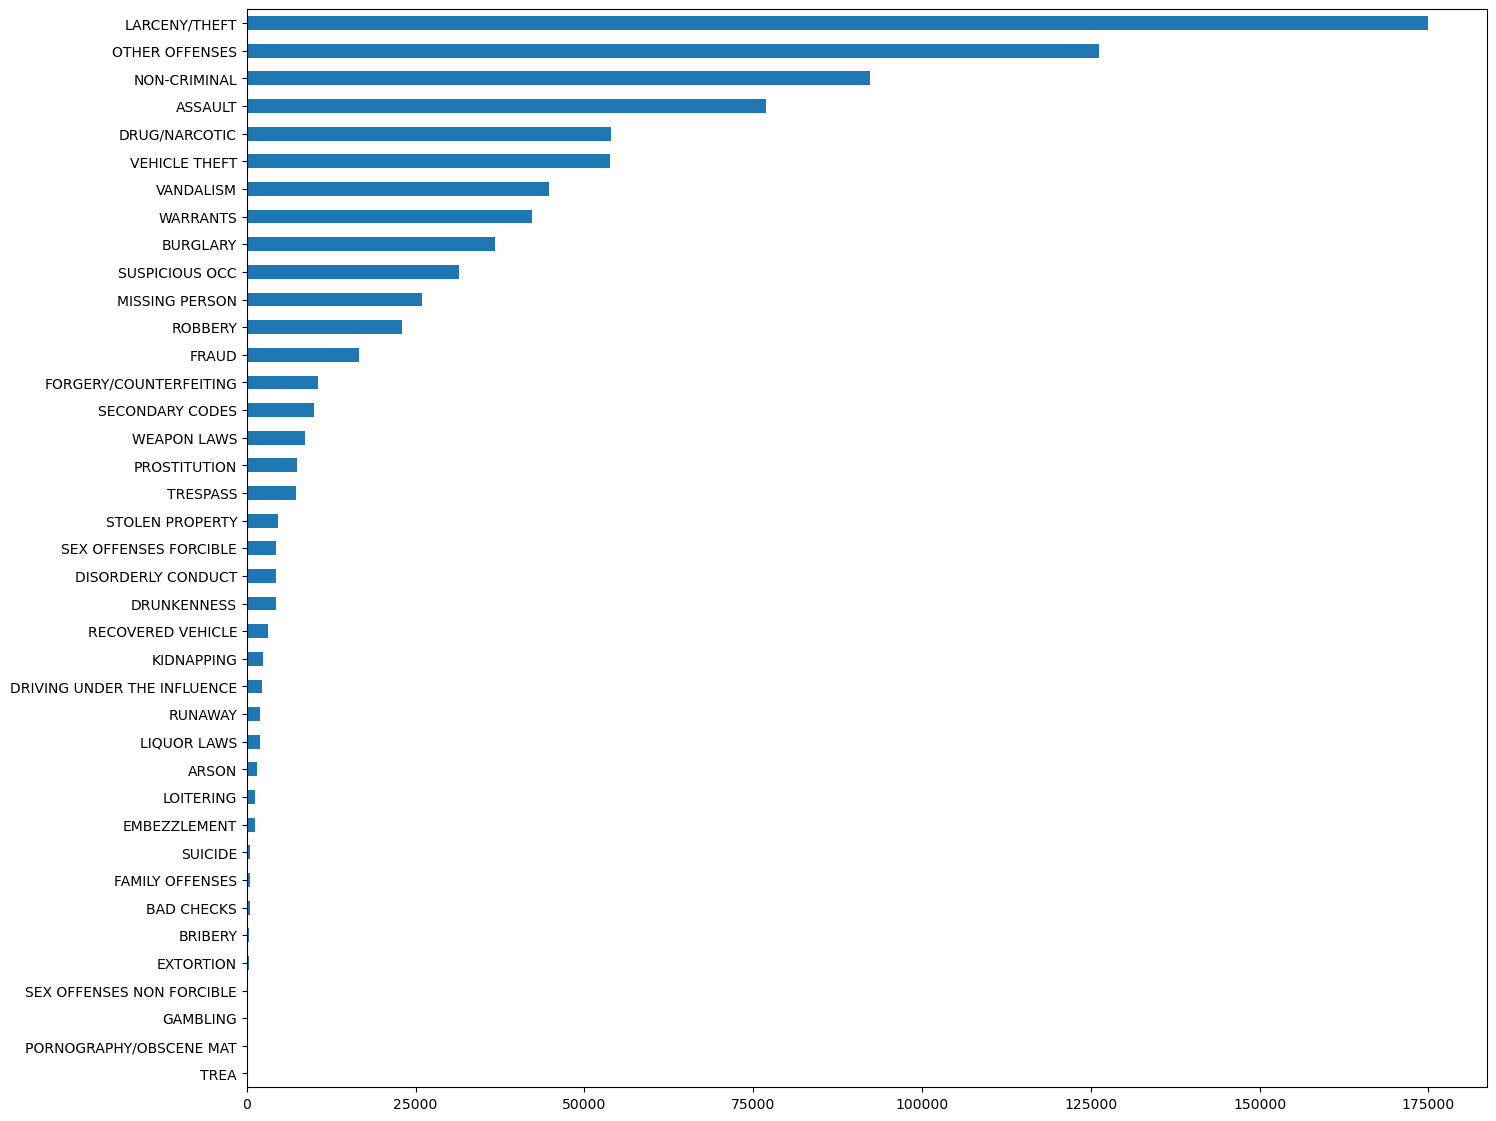

In [11]:
plt.figure(figsize=(16,14))

df_dados['Category'].value_counts(ascending=True).plot(kind='barh')

plt.show()

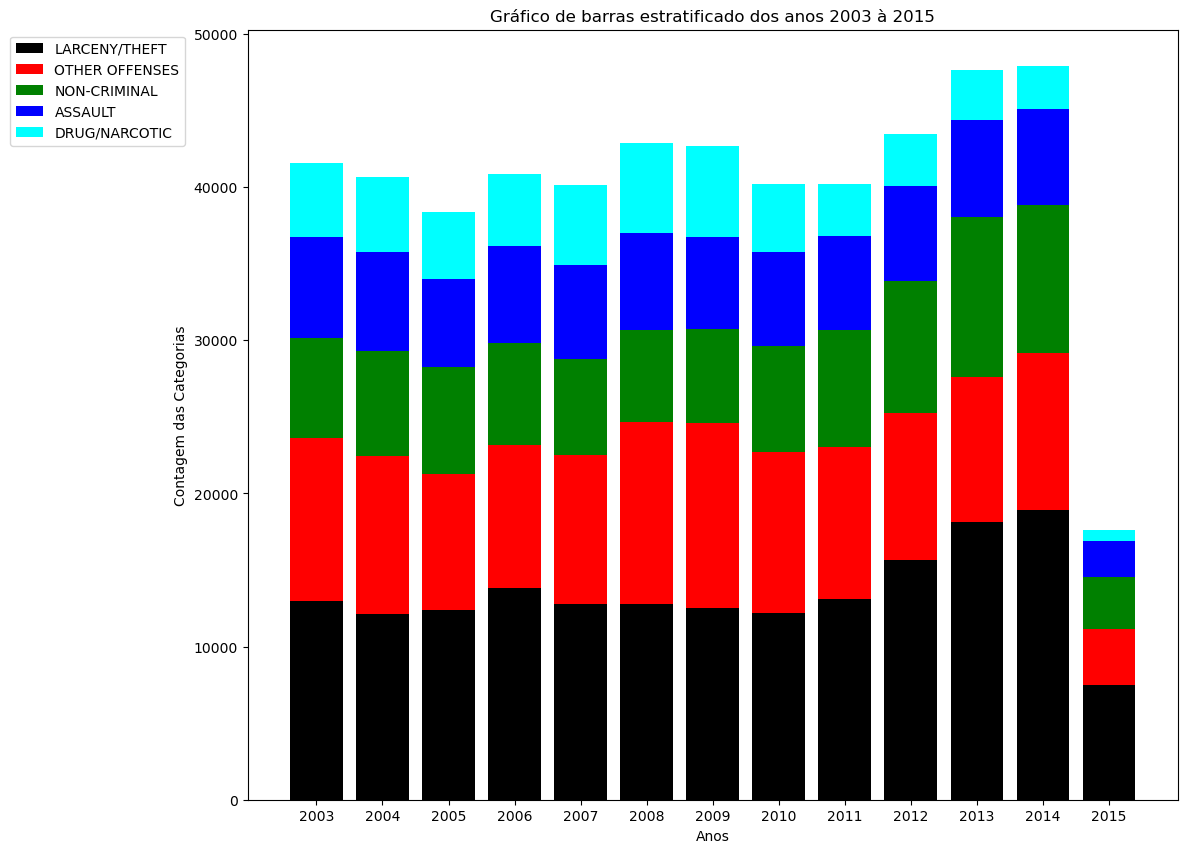

In [12]:
listaCategoryTop5 = df_dados['Category'].value_counts().index.tolist()[:5]
anos = sorted(list(dict.fromkeys([d.date().year for d in df_dados['Dates']])))

dictBarplotCategory = dict()

for category in listaCategoryTop5:
    arrayAux = list()
    
    for ano in anos:
        
        selecao = (df_dados['Dates'] >= str(ano)+'-01-01') & (df_dados['Dates'] <= str(ano+1)+'-01-01')
        dadosAux = df_dados[selecao]
                
        somaCategory = dadosAux[dadosAux['Category'].str.startswith(category)]['Category'].count()
        
        arrayAux.append(somaCategory)
        
    dictBarplotCategory[category] = arrayAux
    
plt.figure(figsize=(12, 10))

soma = np.zeros(anos[-1] - anos[0] + 1)

colors=['black', 'red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'pink', 'orange', 'purple', '#237698', '#AA2498', '#CCDD55',
       '#AA5312', '#866732', '#AA5800', '#777', '#3377EE', '#2F9', '#6C8']
contColor = 0

for category in dictBarplotCategory.keys():
    plt.bar(anos, np.array(dictBarplotCategory[category]), bottom = np.array(soma), color=colors[contColor])
    soma = np.array(dictBarplotCategory[category]) + soma
    
    contColor += 1
    
plt.xticks(anos)

plt.xlabel("Anos")
plt.ylabel("Contagem das Categorias")

plt.legend(listaCategoryTop5, loc = 'best', bbox_to_anchor=(-0.06, 1))
plt.title(f"Gráfico de barras estratificado dos anos {anos[0]} à {anos[-1]}")

plt.show()

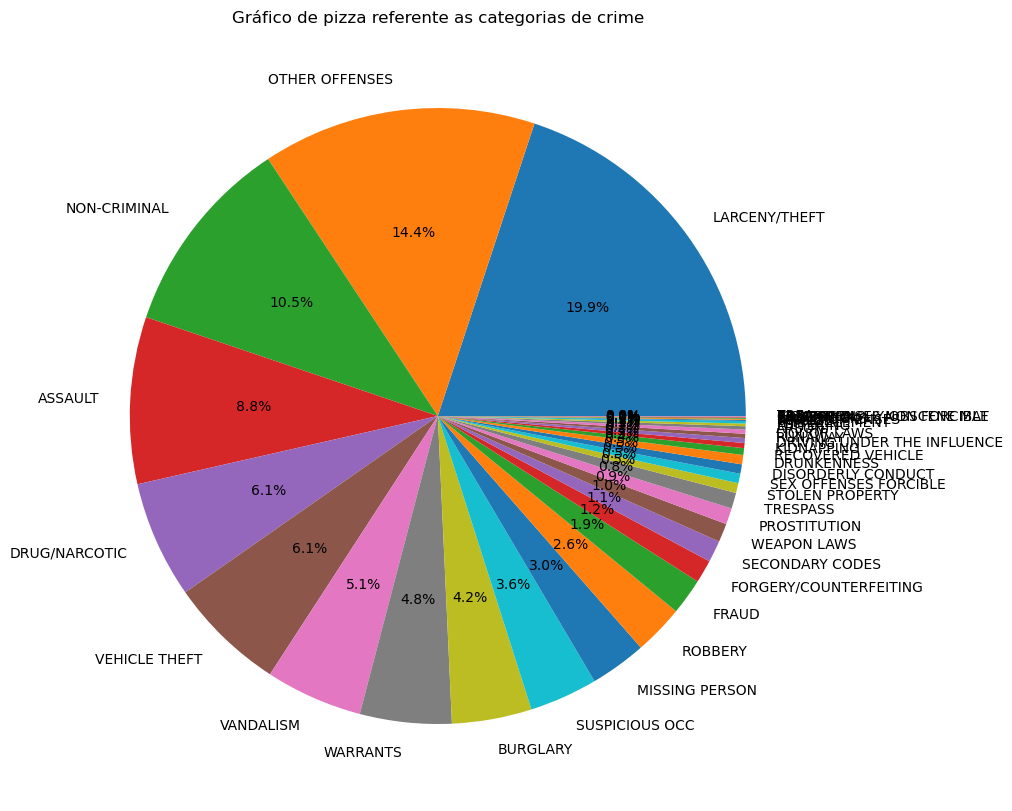

In [13]:
category_value_counts = df_dados['Category'].value_counts()

labels = category_value_counts.index.tolist()
values = category_value_counts.values.tolist()

plt.figure(figsize=(12,10))
plt.pie(values, labels = labels, autopct='%1.1f%%')

plt.title("Gráfico de pizza referente as categorias de crime")

plt.show()

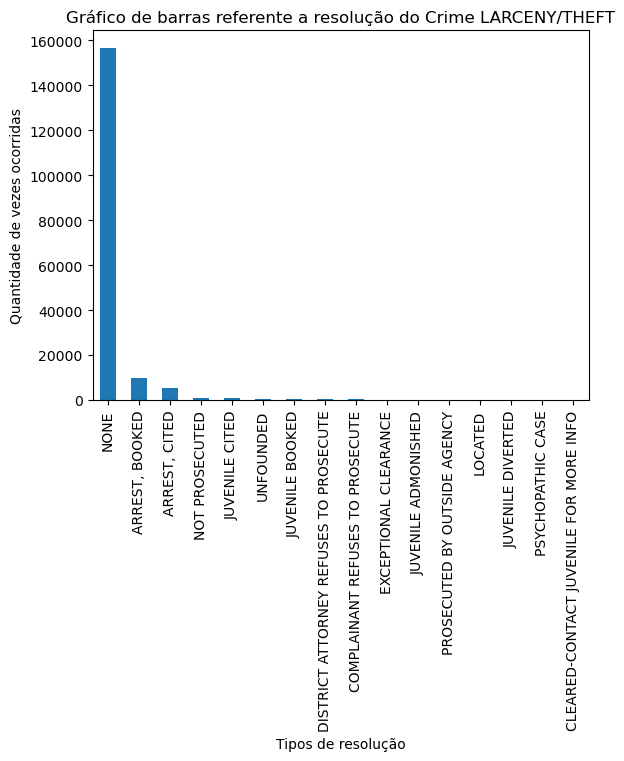

In [14]:
df_dados[df_dados['Category'] == 'LARCENY/THEFT']['Resolution'].value_counts().plot(kind='bar')

plt.title("Gráfico de barras referente a resolução do Crime LARCENY/THEFT")
plt.xlabel("Tipos de resolução")
plt.ylabel("Quantidade de vezes ocorridas")

plt.show()

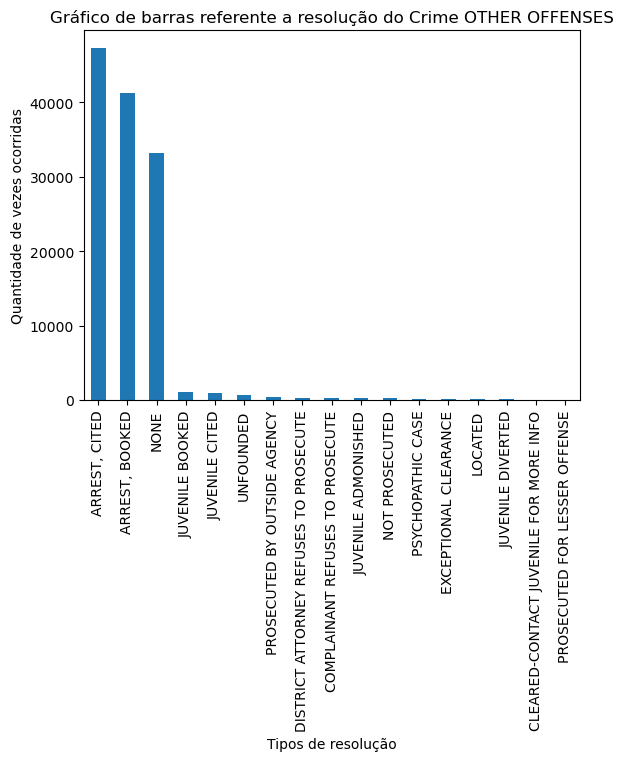

In [15]:
df_dados[df_dados['Category'] == 'OTHER OFFENSES']['Resolution'].value_counts().plot(kind='bar')

plt.title("Gráfico de barras referente a resolução do Crime OTHER OFFENSES")
plt.xlabel("Tipos de resolução")
plt.ylabel("Quantidade de vezes ocorridas")

plt.show()

## 2.2 Analisando descrição

In [16]:
show_report_feature(df_dados, 'Descript')

Quantidade de valores únicos: 879
Quais são os valores únicos: ['WARRANT ARREST' 'TRAFFIC VIOLATION ARREST'
 'GRAND THEFT FROM LOCKED AUTO' 'GRAND THEFT FROM UNLOCKED AUTO'
 'STOLEN AUTOMOBILE' 'PETTY THEFT FROM LOCKED AUTO'
 'MISCELLANEOUS INVESTIGATION' 'MALICIOUS MISCHIEF, VANDALISM OF VEHICLES'
 'FOUND PROPERTY' 'ROBBERY, ARMED WITH A KNIFE'
 'AGGRAVATED ASSAULT WITH BODILY FORCE' 'TRAFFIC VIOLATION'
 'ROBBERY, BODILY FORCE' 'STAY AWAY OR COURT ORDER, NON-DV RELATED'
 'LOST PROPERTY' 'ATTEMPTED THEFT FROM LOCKED VEHICLE'
 'CIVIL SIDEWALKS, CITATION' 'MALICIOUS MISCHIEF, VANDALISM'
 'SUSPICIOUS PACKAGE' 'AIDED CASE, MENTAL DISTURBED'
 'PETTY THEFT SHOPLIFTING' 'PROBATION VIOLATION'
 'STAY AWAY ORDER VIOLATION, DV RELATED'
 'DRIVERS LICENSE, SUSPENDED OR REVOKED' 'STOLEN MOTORCYCLE'
 'GRAND THEFT FROM PERSON' 'BURGLARY, VEHICLE (ARREST MADE)'
 'ATTEMPTED ROBBERY ON THE STREET WITH BODILY FORCE'
 'PETTY THEFT FROM A BUILDING' 'INVESTIGATIVE DETENTION'
 'GRAND THEFT OF PROPERTY' 'STOLE

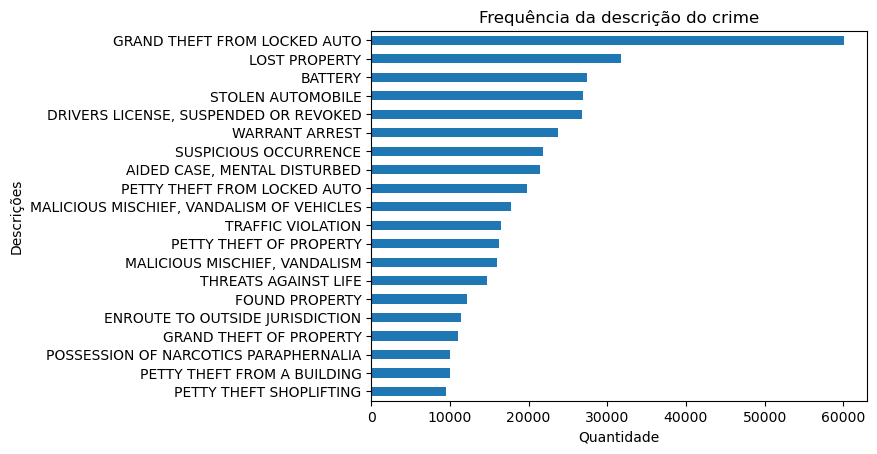

In [17]:
df_dados['Descript'].value_counts(ascending=True)[-20:].plot(kind="barh")

plt.title("Frequência da descrição do crime")
plt.xlabel("Quantidade")
plt.ylabel("Descrições")

plt.savefig("Freq_desc_crimes.jpg", bbox_inches="tight")
plt.show()

## 2.3 Analisando Resolução do crime

In [18]:
show_report_feature(df_dados, 'Resolution')

Quantidade de valores únicos: 17
Quais são os valores únicos: ['ARREST, BOOKED' 'NONE' 'ARREST, CITED' 'PSYCHOPATHIC CASE'
 'JUVENILE BOOKED' 'UNFOUNDED' 'EXCEPTIONAL CLEARANCE' 'LOCATED'
 'CLEARED-CONTACT JUVENILE FOR MORE INFO' 'NOT PROSECUTED'
 'JUVENILE DIVERTED' 'COMPLAINANT REFUSES TO PROSECUTE'
 'JUVENILE ADMONISHED' 'JUVENILE CITED'
 'DISTRICT ATTORNEY REFUSES TO PROSECUTE' 'PROSECUTED BY OUTSIDE AGENCY'
 'PROSECUTED FOR LESSER OFFENSE']
Quantidade de valores nulos: 0
Quantidade por opção de coluna: 
NONE                                      526790
ARREST, BOOKED                            206403
ARREST, CITED                              77004
LOCATED                                    17101
PSYCHOPATHIC CASE                          14534
UNFOUNDED                                   9585
JUVENILE BOOKED                             5564
COMPLAINANT REFUSES TO PROSECUTE            3976
DISTRICT ATTORNEY REFUSES TO PROSECUTE      3934
NOT PROSECUTED                              3

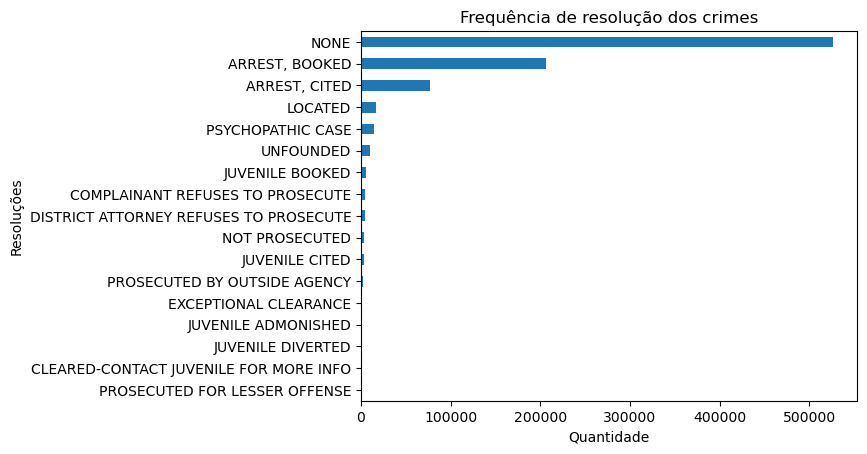

In [19]:
df_dados['Resolution'].value_counts(ascending=True).plot(kind="barh")

plt.title("Frequência de resolução dos crimes")
plt.xlabel("Quantidade")
plt.ylabel("Resoluções")

plt.savefig("Freq_resol_crimes.jpg", bbox_inches="tight")

plt.show()

## 2.4 Analisando dia da semana

In [20]:
show_report_feature(df_dados, 'DayOfWeek')

Quantidade de valores únicos: 7
Quais são os valores únicos: ['Wednesday' 'Tuesday' 'Monday' 'Sunday' 'Saturday' 'Friday' 'Thursday']
Quantidade de valores nulos: 0
Quantidade por opção de coluna: 
Friday       133734
Wednesday    129211
Saturday     126810
Thursday     125038
Tuesday      124965
Monday       121584
Sunday       116707
Name: DayOfWeek, dtype: int64


In [21]:
quant_day_of_week = {'Sunday': 0, 'Monday': 0, 'Tuesday': 0, 'Wednesday': 0, 'Thursday': 0, 'Friday': 0, 'Saturday': 0}
for i in quant_day_of_week.keys():
    quant_day_of_week[i] = df_dados['DayOfWeek'].value_counts()[i]

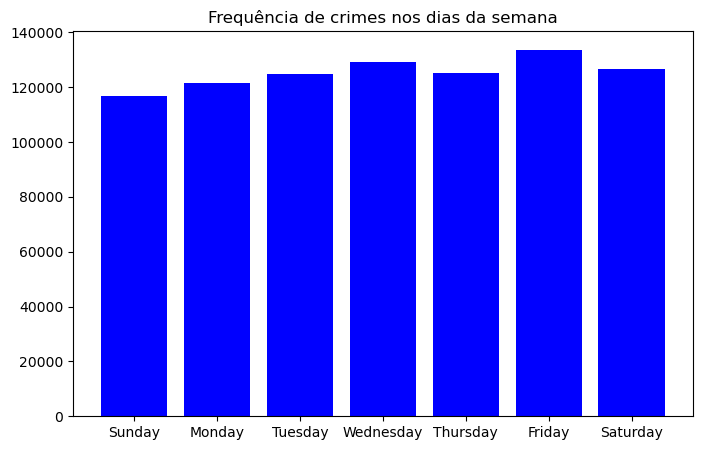

In [22]:
plt.figure(figsize=(8,5))
plt.bar(quant_day_of_week.keys(), quant_day_of_week.values(), color="blue")

plt.title("Frequência de crimes nos dias da semana")
plt.show()

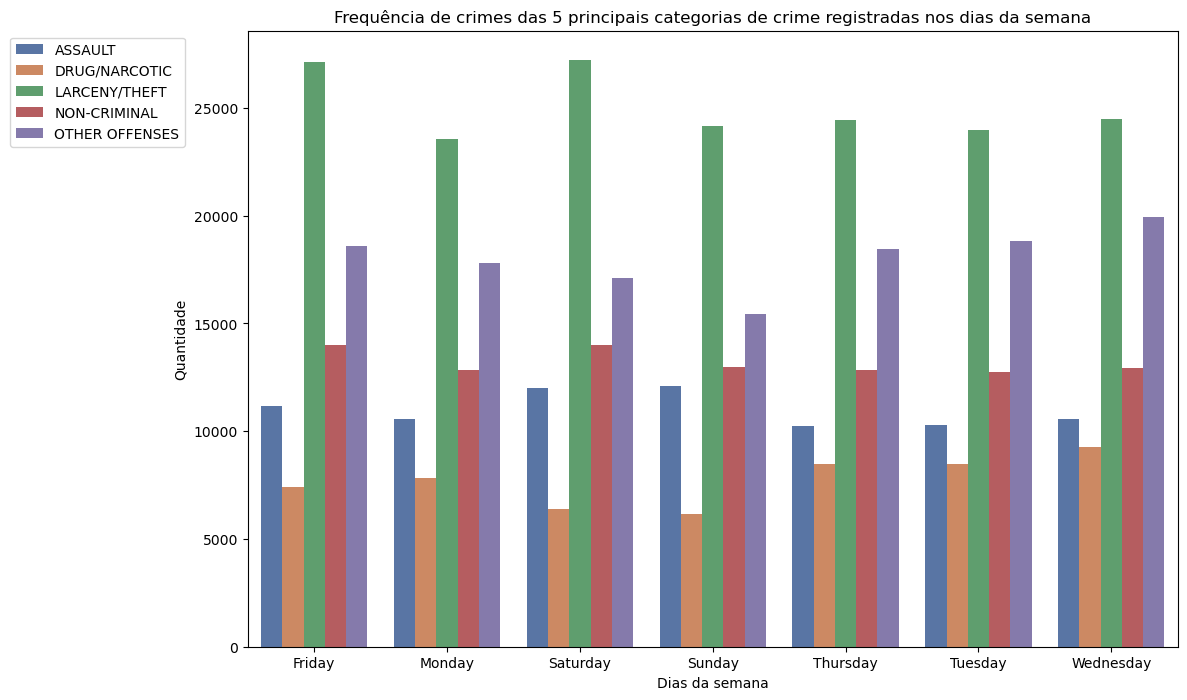

In [23]:
listaCategoryTop5 = df_dados['Category'].value_counts().index.tolist()[:5]

df_dados_filter = df_dados[df_dados['Category'].isin(listaCategoryTop5)]

df_dados_agrupados = df_dados_filter.groupby(['DayOfWeek', 'Category']).size().to_frame('Quantidade').reset_index()

plt.figure(figsize=(12,8))
sns.barplot(x='DayOfWeek', y='Quantidade', hue='Category', data=df_dados_agrupados, palette="deep")

plt.xlabel("Dias da semana")
plt.legend(loc = 'best', bbox_to_anchor=(-0.06, 1))

plt.title("Frequência de crimes das 5 principais categorias de crime registradas nos dias da semana")

plt.show()

In [24]:
def porcentagem_dayOfWeek_category(dados):
    dados['Porcentagem'] = dados['Quantidade'] / df_dados[df_dados['DayOfWeek'] == dados['DayOfWeek']]['DayOfWeek'].count()
    
    return dados

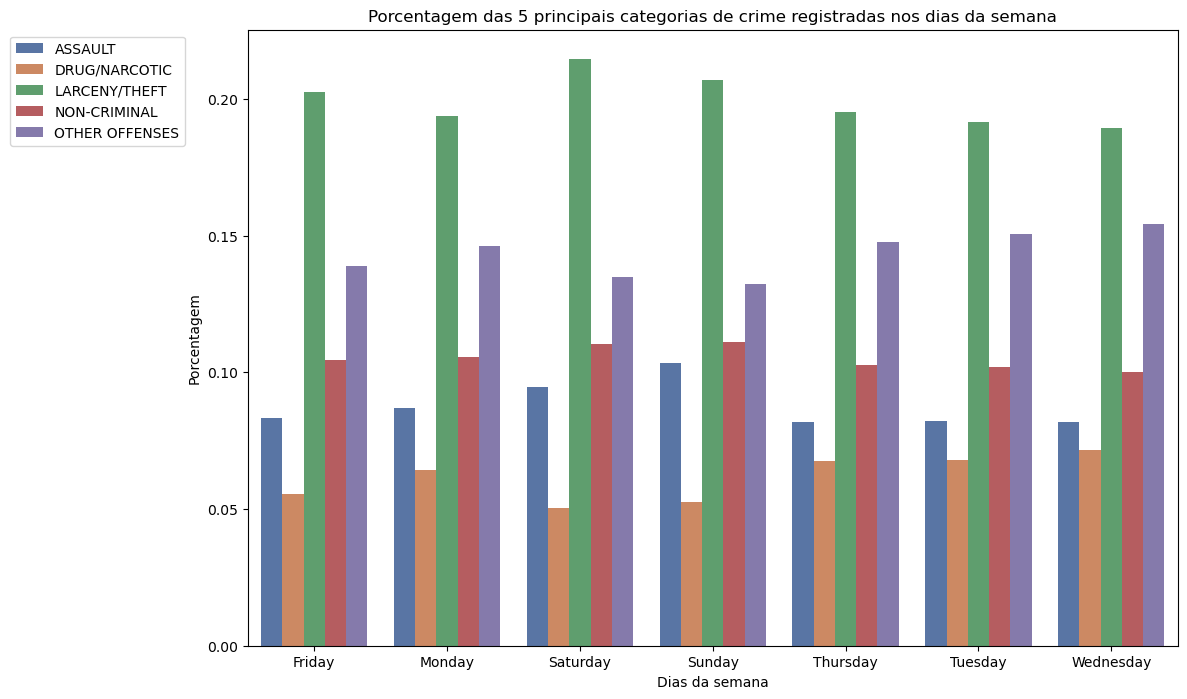

In [25]:
listaCategoryTop5 = df_dados['Category'].value_counts().index.tolist()[:5]

df_dados_filter = df_dados[df_dados['Category'].isin(listaCategoryTop5)]

df_dados_agrupados = df_dados_filter.groupby(['DayOfWeek', 'Category']).size().to_frame('Quantidade').reset_index()
df_dados_agrupados = df_dados_agrupados.apply(porcentagem_dayOfWeek_category, axis = 1)

plt.figure(figsize=(12,8))
sns.barplot(x='DayOfWeek', y='Porcentagem', hue='Category', data=df_dados_agrupados, palette="deep")

plt.ylabel("Porcentagem")
plt.xlabel("Dias da semana")
plt.legend(loc = 'best', bbox_to_anchor=(-0.06, 1))

plt.title("Porcentagem das 5 principais categorias de crime registradas nos dias da semana")

plt.show()

## 2.6 Analisando endereço

In [26]:
show_report_feature(df_dados, 'Address')

Quantidade de valores únicos: 23228
Quais são os valores únicos: ['OAK ST / LAGUNA ST' 'VANNESS AV / GREENWICH ST'
 '1500 Block of LOMBARD ST' '100 Block of BRODERICK ST'
 '0 Block of TEDDY AV' 'AVALON AV / PERU AV' 'KIRKWOOD AV / DONAHUE ST'
 '600 Block of 47TH AV' 'JEFFERSON ST / LEAVENWORTH ST'
 '0 Block of ESCOLTA WY' 'TURK ST / JONES ST' 'FILLMORE ST / GEARY BL'
 '200 Block of WILLIAMS AV' '0 Block of MENDELL ST' 'EDDY ST / JONES ST'
 'GODEUS ST / MISSION ST' 'MENDELL ST / HUDSON AV' '100 Block of JONES ST'
 '200 Block of EVELYN WY' '1600 Block of VALENCIA ST'
 'FILLMORE ST / LOMBARD ST' '300 Block of OFARRELL ST'
 '2000 Block of BUSH ST' '500 Block of COLLEGE AV' '19TH AV / SANTIAGO ST'
 '2000 Block of 41ST AV' '1300 Block of WEBSTER ST'
 '400 Block of CASTRO ST' '1500 Block of FILLMORE ST'
 '1600 Block of WEBSTER ST' 'KING ST / 3RD ST' 'VALLEJO ST / BUCHANAN ST'
 'CALIFORNIA ST / BUCHANAN ST' '1400 Block of HOLLOWAY AV'
 '0 Block of WINDING WY' '700 Block of MARKET ST'
 '1600 Bl

## 2.7 Analisando Address

In [27]:
show_report_feature(df_dados, 'Address')

Quantidade de valores únicos: 23228
Quais são os valores únicos: ['OAK ST / LAGUNA ST' 'VANNESS AV / GREENWICH ST'
 '1500 Block of LOMBARD ST' '100 Block of BRODERICK ST'
 '0 Block of TEDDY AV' 'AVALON AV / PERU AV' 'KIRKWOOD AV / DONAHUE ST'
 '600 Block of 47TH AV' 'JEFFERSON ST / LEAVENWORTH ST'
 '0 Block of ESCOLTA WY' 'TURK ST / JONES ST' 'FILLMORE ST / GEARY BL'
 '200 Block of WILLIAMS AV' '0 Block of MENDELL ST' 'EDDY ST / JONES ST'
 'GODEUS ST / MISSION ST' 'MENDELL ST / HUDSON AV' '100 Block of JONES ST'
 '200 Block of EVELYN WY' '1600 Block of VALENCIA ST'
 'FILLMORE ST / LOMBARD ST' '300 Block of OFARRELL ST'
 '2000 Block of BUSH ST' '500 Block of COLLEGE AV' '19TH AV / SANTIAGO ST'
 '2000 Block of 41ST AV' '1300 Block of WEBSTER ST'
 '400 Block of CASTRO ST' '1500 Block of FILLMORE ST'
 '1600 Block of WEBSTER ST' 'KING ST / 3RD ST' 'VALLEJO ST / BUCHANAN ST'
 'CALIFORNIA ST / BUCHANAN ST' '1400 Block of HOLLOWAY AV'
 '0 Block of WINDING WY' '700 Block of MARKET ST'
 '1600 Bl

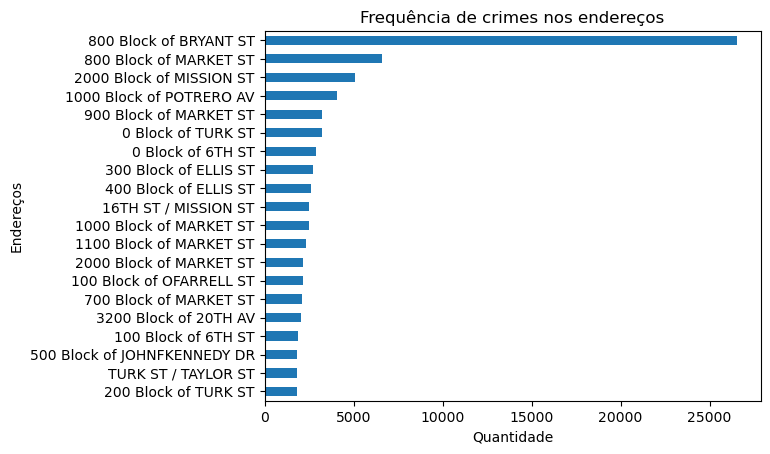

In [30]:
df_dados['Address'].value_counts(ascending=True)[-20:].plot(kind='barh')

plt.title("Frequência de crimes nos endereços")

plt.ylabel("Endereços")
plt.xlabel("Quantidade")

plt.show()

In [55]:
#df_dados['Number_Location'] = df_dados
df_dados['Name_Location'] = df_dados['Address'].str.replace(r'^[0-9]+', "")

df_dados.head()

C:\Users\wende\AppData\Local\Temp\ipykernel_11728\776798076.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_dados['Name_Location'] = df_dados['Address'].str.replace(r'^[0-9]+', "")


Dates        Category                      Descript  \
0 2015-05-13 23:53:00        WARRANTS                WARRANT ARREST   
1 2015-05-13 23:53:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
2 2015-05-13 23:33:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
3 2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   
4 2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   

   DayOfWeek PdDistrict      Resolution                    Address  \
0  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
1  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
2  Wednesday   NORTHERN  ARREST, BOOKED  VANNESS AV / GREENWICH ST   
3  Wednesday   NORTHERN            NONE   1500 Block of LOMBARD ST   
4  Wednesday       PARK            NONE  100 Block of BRODERICK ST   

            X          Y  Year  Month  DayOfMonth  Hours  Minutes  \
0 -122.425892  37.774599  2015      5          13     23       53   
1 -122.425892  37.774599  2015      5          13     23       53   
2 -122.424363  37.800414  2015      5          13     23       33   
3 -122.426995  37.800873  2015      5          13     23       30   
4 -122.438738  37.771541  2015      5          13     23       30   

               Name_Location  
0         OAK ST / LAGUNA ST  
1         OAK ST / LAGUNA ST  
2  VANNESS AV / GREENWICH ST  
3        Block of LOMBARD ST  
4      Block of BRODERICK ST

In [59]:
df_dados[df_dados['Address'].str.contains("TH ST")].head()

Dates        Category                               Descript  \
9  2015-05-13 23:00:00   LARCENY/THEFT           GRAND THEFT FROM LOCKED AUTO   
10 2015-05-13 22:58:00   LARCENY/THEFT           PETTY THEFT FROM LOCKED AUTO   
45 2015-05-13 20:00:00  OTHER OFFENSES  DRIVERS LICENSE, SUSPENDED OR REVOKED   
57 2015-05-13 19:30:00   LARCENY/THEFT           GRAND THEFT FROM LOCKED AUTO   
64 2015-05-13 19:15:00   LARCENY/THEFT           PETTY THEFT FROM LOCKED AUTO   

    DayOfWeek PdDistrict     Resolution                        Address  \
9   Wednesday    CENTRAL           NONE  JEFFERSON ST / LEAVENWORTH ST   
10  Wednesday    CENTRAL           NONE  JEFFERSON ST / LEAVENWORTH ST   
45  Wednesday    CENTRAL  ARREST, CITED    800 Block of LEAVENWORTH ST   
57  Wednesday   SOUTHERN           NONE          HARRISON ST / 10TH ST   
64  Wednesday   SOUTHERN           NONE           300 Block of 10TH ST   

             X          Y  Year  Month  DayOfMonth  Hours  Minutes  \
9  -122.419088  37.807802  2015      5          13     23        0   
10 -122.419088  37.807802  2015      5          13     22       58   
45 -122.415212  37.788871  2015      5          13     20        0   
57 -122.411279  37.771579  2015      5          13     19       30   
64 -122.411637  37.771787  2015      5          13     19       15   

                    Name_Location  
9   JEFFERSON ST / LEAVENWORTH ST  
10  JEFFERSON ST / LEAVENWORTH ST  
45        Block of LEAVENWORTH ST  
57          HARRISON ST / 10TH ST  
64               Block of 10TH ST

In [60]:
show_report_feature(df_dados, 'Name_Location')

Quantidade de valores únicos: 12907
Quais são os valores únicos: ['OAK ST / LAGUNA ST' 'VANNESS AV / GREENWICH ST' ' Block of LOMBARD ST'
 ' Block of BRODERICK ST' ' Block of TEDDY AV' 'AVALON AV / PERU AV'
 'KIRKWOOD AV / DONAHUE ST' ' Block of 47TH AV'
 'JEFFERSON ST / LEAVENWORTH ST' ' Block of ESCOLTA WY'
 'TURK ST / JONES ST' 'FILLMORE ST / GEARY BL' ' Block of WILLIAMS AV'
 ' Block of MENDELL ST' 'EDDY ST / JONES ST' 'GODEUS ST / MISSION ST'
 'MENDELL ST / HUDSON AV' ' Block of JONES ST' ' Block of EVELYN WY'
 ' Block of VALENCIA ST' 'FILLMORE ST / LOMBARD ST'
 ' Block of OFARRELL ST' ' Block of BUSH ST' ' Block of COLLEGE AV'
 'TH AV / SANTIAGO ST' ' Block of 41ST AV' ' Block of WEBSTER ST'
 ' Block of CASTRO ST' ' Block of FILLMORE ST' 'KING ST / 3RD ST'
 'VALLEJO ST / BUCHANAN ST' 'CALIFORNIA ST / BUCHANAN ST'
 ' Block of HOLLOWAY AV' ' Block of WINDING WY' ' Block of MARKET ST'
 ' Block of STOCKTON ST' ' Block of LEAVENWORTH ST'
 ' Block of CRESCENT AV' 'LINCOLN WY / 14TH AV'

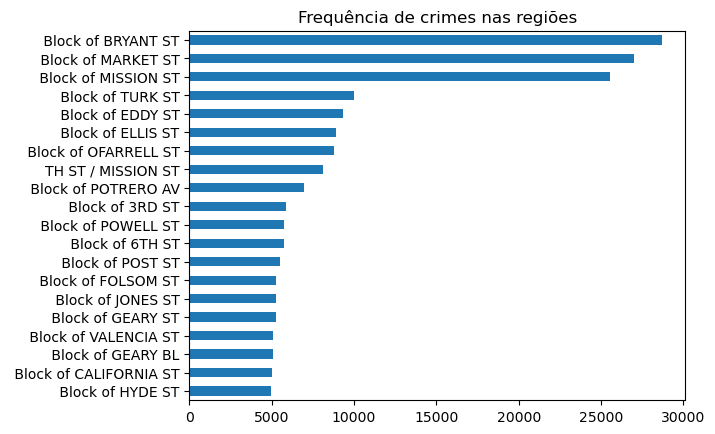

In [61]:
df_dados['Name_Location'].value_counts(ascending=True)[-20:].plot(kind='barh')

plt.title("Frequência de crimes nas regiões")

plt.show()

## 2.8 Analisando latitude e longitude

In [62]:
df_dados[df_dados['Y'] > 85].head()

Dates        Category  \
660485 2005-12-30 17:00:00   LARCENY/THEFT   
660711 2005-12-30 00:34:00         ASSAULT   
660712 2005-12-30 00:34:00         ASSAULT   
661106 2005-12-29 00:07:00    NON-CRIMINAL   
666430 2005-11-30 11:25:00  OTHER OFFENSES   

                                    Descript  DayOfWeek  PdDistrict  \
660485          GRAND THEFT FROM LOCKED AUTO     Friday  TENDERLOIN   
660711           INFLICT INJURY ON COHABITEE     Friday     BAYVIEW   
660712  AGGRAVATED ASSAULT WITH BODILY FORCE     Friday     BAYVIEW   
661106          AIDED CASE, MENTAL DISTURBED   Thursday  TENDERLOIN   
666430                     TRAFFIC VIOLATION  Wednesday  TENDERLOIN   

               Resolution                          Address      X     Y  Year  \
660485               NONE      5THSTNORTH ST / OFARRELL ST -120.5  90.0  2005   
660711     ARREST, BOOKED  JAMESLICKFREEWAY HY / SILVER AV -120.5  90.0  2005   
660712     ARREST, BOOKED  JAMESLICKFREEWAY HY / SILVER AV -120.5  90.0  2005   
661106  PSYCHOPATHIC CASE          5THSTNORTH ST / EDDY ST -120.5  90.0  2005   
666430      ARREST, CITED         5THSTNORTH ST / ELLIS ST -120.5  90.0  2005   

        Month  DayOfMonth  Hours  Minutes                    Name_Location  
660485     12          30     17        0       THSTNORTH ST / OFARRELL ST  
660711     12          30      0       34  JAMESLICKFREEWAY HY / SILVER AV  
660712     12          30      0       34  JAMESLICKFREEWAY HY / SILVER AV  
661106     12          29      0        7           THSTNORTH ST / EDDY ST  
666430     11          30     11       25          THSTNORTH ST / ELLIS ST

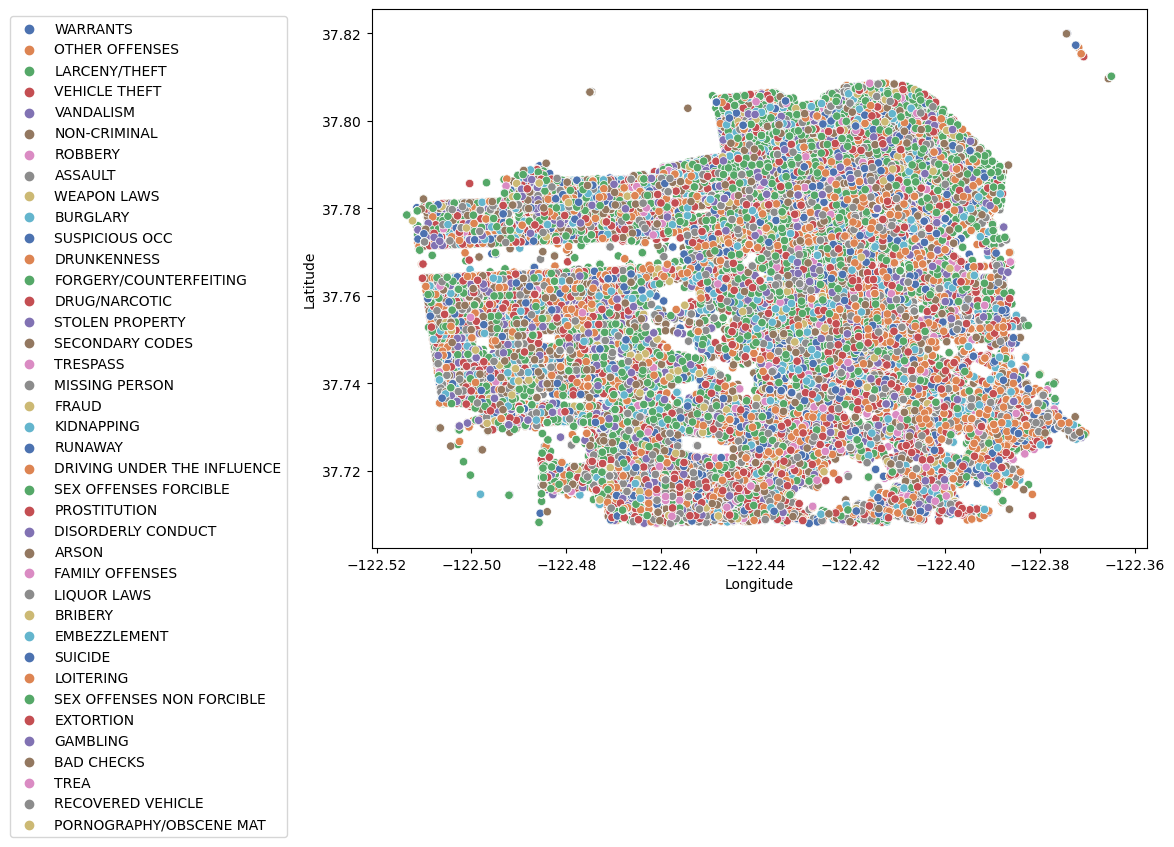

In [30]:
plt.figure(figsize=(10, 7))

df_dados_filter = df_dados[df_dados['Y'] < 85]

sns.scatterplot(df_dados_filter, x = 'X', y = 'Y', hue = 'Category', palette="deep")

plt.legend(loc = 'best', bbox_to_anchor=(-0.1, 1))

plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.show()

## 2.9 Analisando nome do distrito do departamento de polícia

In [31]:
show_report_feature(df_dados, 'PdDistrict')

Quantidade de valores únicos: 10
Quais são os valores únicos: ['NORTHERN' 'PARK' 'INGLESIDE' 'BAYVIEW' 'RICHMOND' 'CENTRAL' 'TARAVAL'
 'TENDERLOIN' 'MISSION' 'SOUTHERN']
Quantidade de valores nulos: 0
Quantidade por opção de coluna: 
SOUTHERN      157182
MISSION       119908
NORTHERN      105296
BAYVIEW        89431
CENTRAL        85460
TENDERLOIN     81809
INGLESIDE      78845
TARAVAL        65596
PARK           49313
RICHMOND       45209
Name: PdDistrict, dtype: int64


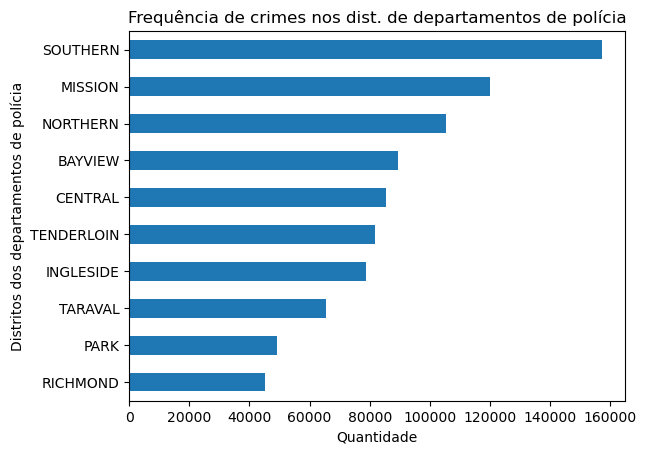

In [32]:
df_dados['PdDistrict'].value_counts(ascending=True).plot(kind='barh')

plt.title("Frequência de crimes nos dist. de departamentos de polícia")

plt.xlabel("Quantidade")
plt.ylabel("Distritos dos departamentos de polícia")

plt.savefig("Freq_depart_polic_crimes.jpg", bbox_inches="tight")

plt.show()

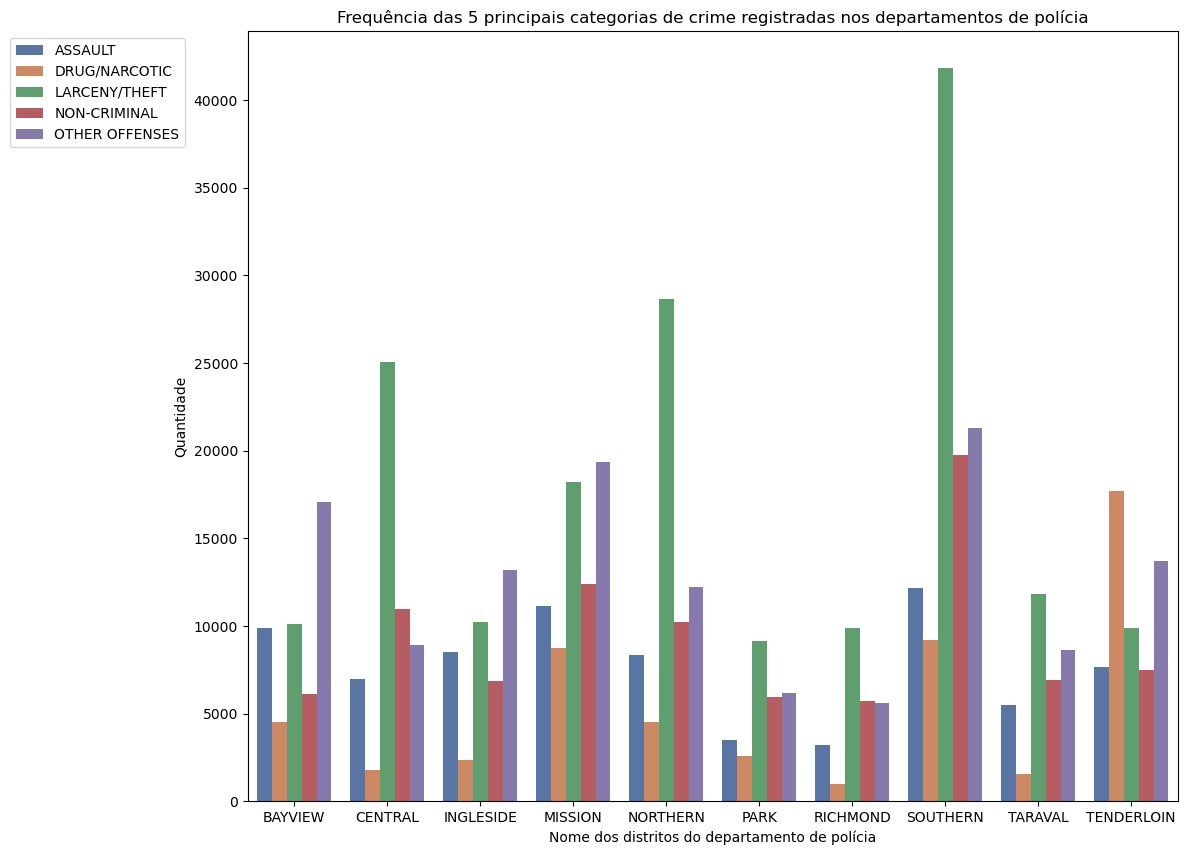

In [33]:
listaCategoryTop5 = df_dados['Category'].value_counts().index.tolist()[:5]

df_dados_filter = df_dados[df_dados['Category'].isin(listaCategoryTop5)]

df_dados_agrupados = df_dados_filter.groupby(['PdDistrict', 'Category']).size().to_frame('Quantidade').reset_index()

plt.figure(figsize=(12,10))
sns.barplot(x='PdDistrict', y='Quantidade', hue='Category', data=df_dados_agrupados, palette="deep")

plt.xlabel("Nome dos distritos do departamento de polícia")
plt.legend(loc = 'best', bbox_to_anchor=(-0.06, 1))

plt.title("Frequência das 5 principais categorias de crime registradas nos departamentos de polícia")

plt.show()

In [34]:
def porcentagem_categoria_PdDistrict(dados):
    dados['Porcentagem'] = dados['Quantidade'] / df_dados[df_dados['PdDistrict'] == dados['PdDistrict']]['PdDistrict'].count()
    
    return dados

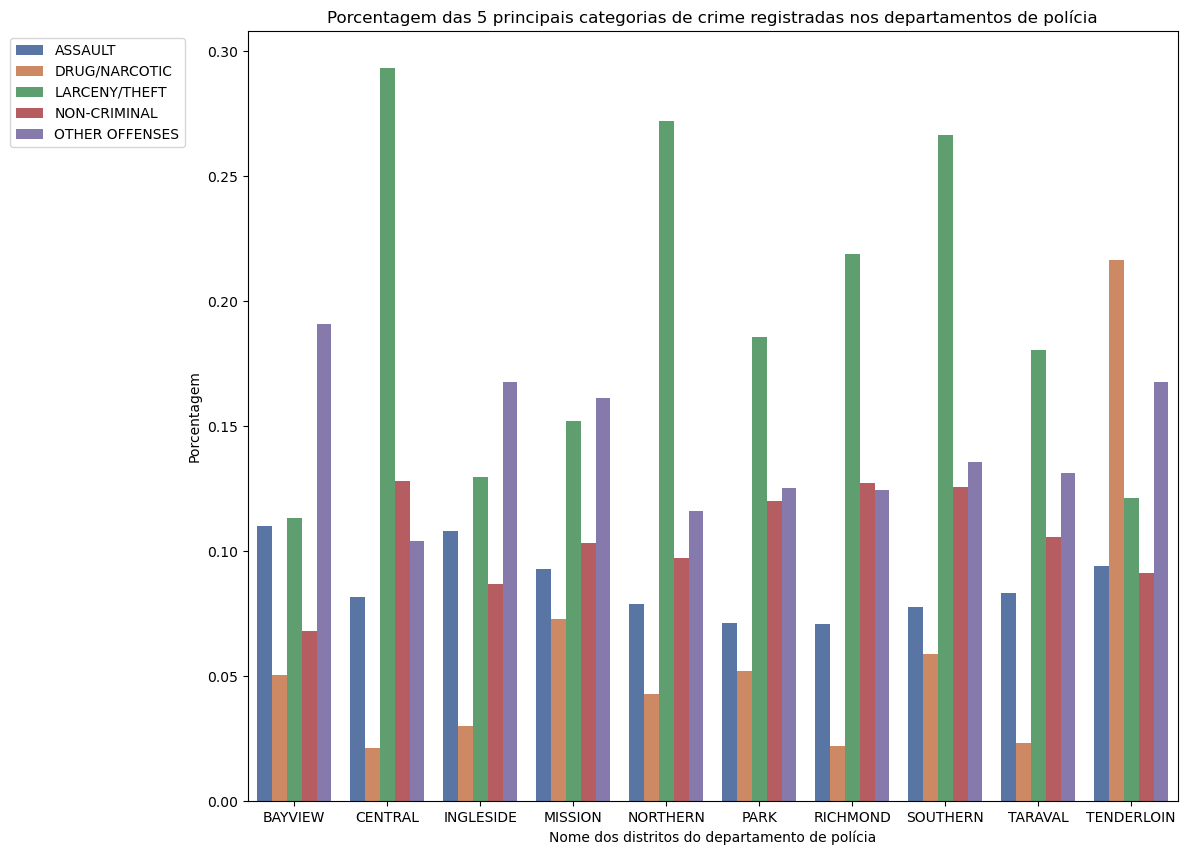

In [35]:
listaCategoryTop5 = df_dados['Category'].value_counts().index.tolist()[:5]

df_dados_filter = df_dados[df_dados['Category'].isin(listaCategoryTop5)]

df_dados_agrupados = df_dados_filter.groupby(['PdDistrict', 'Category']).size().to_frame('Quantidade').reset_index()
df_dados_agrupados = df_dados_agrupados.apply(porcentagem_categoria_PdDistrict, axis = 1)

plt.figure(figsize=(12,10))
sns.barplot(x='PdDistrict', y='Porcentagem', hue='Category', data=df_dados_agrupados, palette="deep")

plt.xlabel("Nome dos distritos do departamento de polícia")
plt.legend(loc = 'best', bbox_to_anchor=(-0.06, 1))

plt.title("Porcentagem das 5 principais categorias de crime registradas nos departamentos de polícia")

plt.savefig("porcent_categ_depart_polic.jpg", bbox_inches="tight")

plt.show()

In [36]:
df_dados_agrupados = df_dados.groupby('PdDistrict')['Category'].value_counts()

## 2.10 Analisando Data

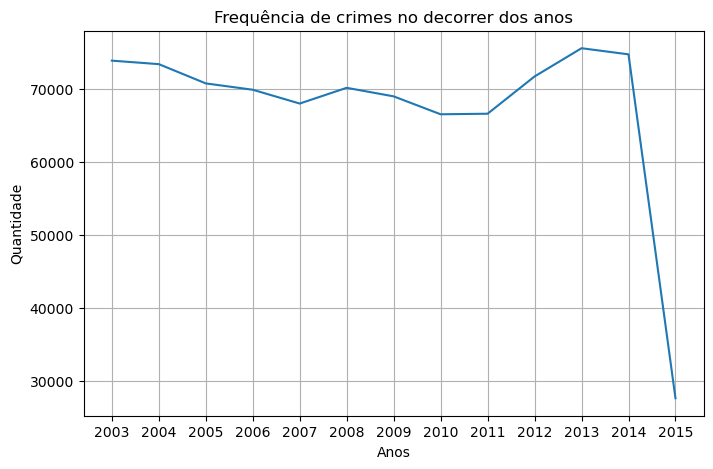

In [37]:
plt.figure(figsize=(8,5))

category_for_years = df_dados['Year'].value_counts().sort_index()

category_for_years.plot()

plt.title("Frequência de crimes no decorrer dos anos")

plt.xticks(category_for_years.index)

plt.ylabel("Quantidade")
plt.xlabel("Anos")

plt.grid()

plt.savefig("freq_crimes_anos.jpg", bbox_inches="tight")

plt.show()

In [38]:
g = sns.FacetGrid(df_dados, col='Category', col_wrap=5, height=15)

g = g.map(sns.countplot, 'Year', order=np.sort(df_dados['Year'].unique()))

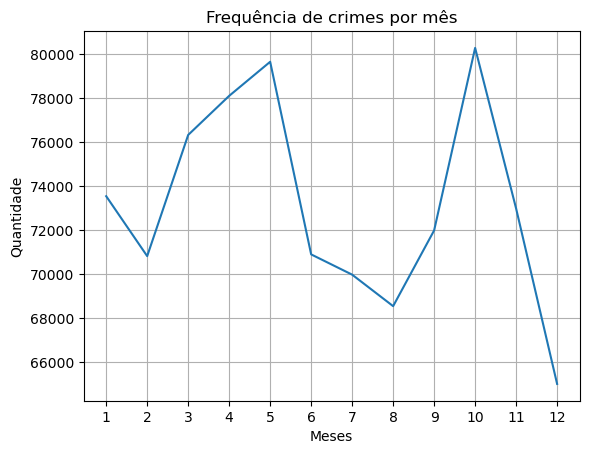

In [39]:
category_for_months = df_dados['Month'].value_counts().sort_index()

category_for_months.plot()

plt.title("Frequência de crimes por mês")

plt.xticks(category_for_months.index)

plt.ylabel("Quantidade")
plt.xlabel("Meses")

plt.grid()

plt.savefig("freq_crimes_meses.jpg", bbox_inches="tight")

plt.show()

In [40]:
g = sns.FacetGrid(df_dados, col='Category', col_wrap=5, height=15)

g = g.map(sns.countplot, 'Month', order=np.sort(df_dados['Month'].unique()))

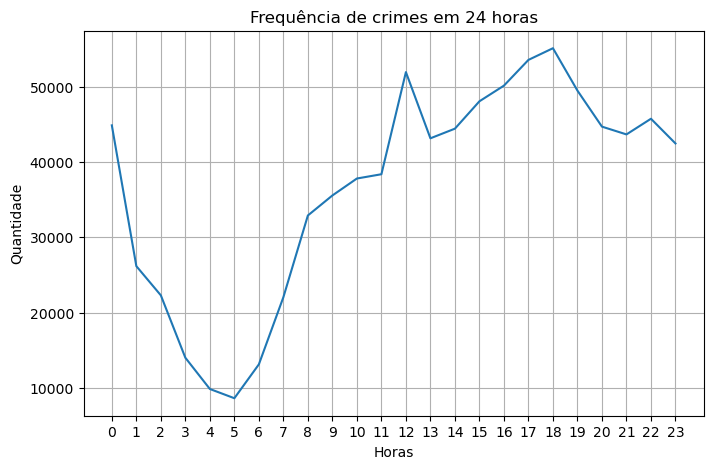

In [40]:
plt.figure(figsize=(8,5))
category_for_hours = df_dados['Hours'].value_counts().sort_index()

category_for_hours.plot()

plt.title("Frequência de crimes em 24 horas")
plt.xticks(category_for_hours.index)

plt.ylabel("Quantidade")
plt.xlabel("Horas")

plt.grid()

plt.savefig("freq_crimes_horas.jpg", bbox_inches="tight")

plt.show()

In [42]:
sns.set(font_scale=2.5)

In [43]:
g = sns.FacetGrid(df_dados, col='Category', col_wrap=5, height=15)

g = g.map(plt.hist, 'Hours', bins=np.arange(0, 23), color="c")

In [44]:
sns.set(font_scale=1)

## 3 UTILIZANDO MODELOS E EXTRAINDO FEATURES

## 3.1 Usando TSNE

df_features = df_dados.drop(columns=['Category', 'Resolution', 'Descript', 'Dates', 'Address'])

df_features = pd.get_dummies(df_features, columns=['PdDistrict', 'DayOfWeek'])

target = df_dados['Category']

model = TSNE(n_components=2, learning_rate='auto')
array_red = model.fit_transform(df_features)

df_tsne = pd.DataFrame(array_red, columns=['com1', 'com2'])

df_tsne['target'] = target

sns.scatterplot(data=df_tsne, x='com1', y='com2', hue='target', palette='deep')

plt.show()

sns.scatterplot(data=df_tsne, x='com1', y='com2', hue='target', palette='deep')

plt.legend(loc = 'best', bbox_to_anchor=(-0.06, 1))
plt.show()

In [44]:
# Convert it to a GeoDataFrame by transforming the Latitude/Longitude coordinates 
#loc_crs = {'init': 'epsg:4326'}
#loc_geom = [Point(xy) for xy in zip(MinMaxScaler.fit_transform(df_dados['X']), MinMaxScaler.fit_transform(df_dados['Y']))]
#geo_df = gpd.GeoDataFrame(df_dados, crs=loc_crs, geometry=loc_geom)

# Plot the GeoDataFrame
#geo_df.plot()

## 3.2 Utilizando aprendizado não supervisionados (K-Means e DBSCAN)

### 3.2.1 Preparando dados para modelos não supervisionados

In [ ]:
min_max_scaler = MinMaxScaler()
stardard_scaler = StandardScaler()

In [46]:
df_dados_train = df_dados.drop(['Category', 'Resolution', 'Descript', 'Dates', 'Address', 'Name_Location'], axis = 1)
df_dados_train = pd.get_dummies(df_dados_train)
df_dados_train = df_dados_train[df_dados_train['Y'] < 85]

#df_dados_train[['X', 'Y']] = stardard_scaler.fit_transform(df_dados_train[['X','Y']])

df_dados_train.head()

X          Y  Year  Month  DayOfMonth  Hours  Minutes  \
0 -122.425892  37.774599  2015      5          13     23       53   
1 -122.425892  37.774599  2015      5          13     23       53   
2 -122.424363  37.800414  2015      5          13     23       33   
3 -122.426995  37.800873  2015      5          13     23       30   
4 -122.438738  37.771541  2015      5          13     23       30   

   DayOfWeek_Friday  DayOfWeek_Monday  DayOfWeek_Saturday  ...  \
0                 0                 0                   0  ...   
1                 0                 0                   0  ...   
2                 0                 0                   0  ...   
3                 0                 0                   0  ...   
4                 0                 0                   0  ...   

   PdDistrict_BAYVIEW  PdDistrict_CENTRAL  PdDistrict_INGLESIDE  \
0                   0                   0                     0   
1                   0                   0                     0   
2                   0                   0                     0   
3                   0                   0                     0   
4                   0                   0                     0   

   PdDistrict_MISSION  PdDistrict_NORTHERN  PdDistrict_PARK  \
0                   0                    1                0   
1                   0                    1                0   
2                   0                    1                0   
3                   0                    1                0   
4                   0                    0                1   

   PdDistrict_RICHMOND  PdDistrict_SOUTHERN  PdDistrict_TARAVAL  \
0                    0                    0                   0   
1                    0                    0                   0   
2                    0                    0                   0   
3                    0                    0                   0   
4                    0                    0                   0   

   PdDistrict_TENDERLOIN  
0                      0  
1                      0  
2                      0  
3                      0  
4                      0  

[5 rows x 24 columns]

In [47]:
X = df_dados_train.values

### 3.2.2 Utilizando método "elbow" para ver o melhor número de clusters

In [48]:
def calculate_wcss(data):
    wcss = []
    for n in range(2, 21):
        kmeans = KMeans(n_clusters=n, n_init='auto', init='random')
        kmeans.fit(X=data)
        wcss.append(kmeans.inertia_)

    return wcss

### 3.2.3 Cálculo que me retorna o melhor número de clusters

In [49]:
def optimal_number_of_clusters(wcss):
    x1, y1 = 2, wcss[0]
    x2, y2 = 20, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = math.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances.index(max(distances)) + 2

In [50]:
n = 7

In [51]:
sum_of_squares = calculate_wcss(X)

n = optimal_number_of_clusters(sum_of_squares) # calculando a quantidade ótima de clusters

print(n)

7


### 3.2.4 Plotagem do gráfico do método "elbow"

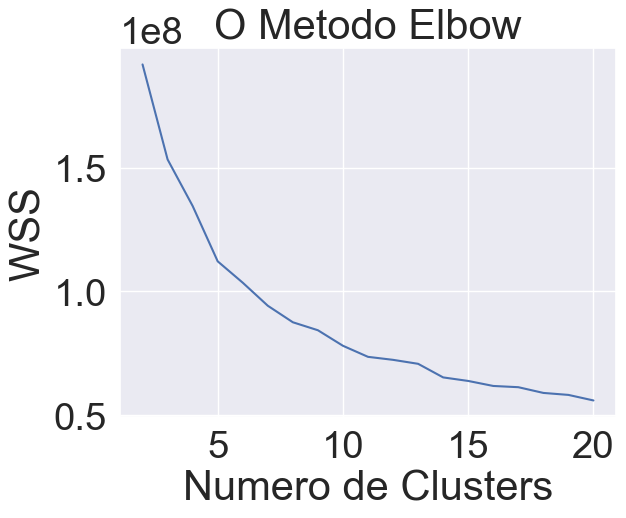

In [52]:
plt.plot(range(2, 21), sum_of_squares)

plt.title('O Metodo Elbow')
plt.xlabel('Numero de Clusters')
plt.ylabel('WSS')
plt.show()

### 3.2.5 Aplicação do Kmeans e sua respectiva visualização nas variáveis latitude e longitude

In [53]:
kmeans = KMeans(n_clusters=n, init='random', n_init='auto', random_state=3).fit(X)

In [54]:
sns.set(font_scale=1)

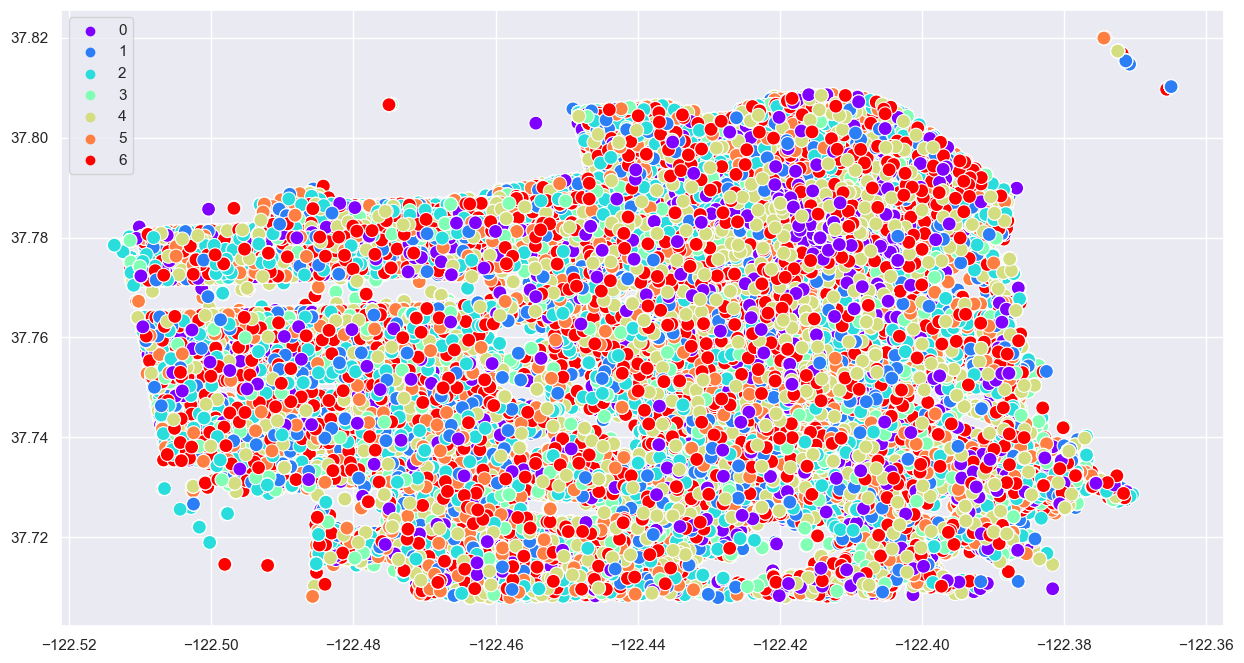

In [55]:
plt.figure(figsize=(15,8))

var1 = 0
var2 = 1

cont = 0

#plt.scatter(X[:,var1], X[:,var2], s=100, c=kmeans.labels_, cmap='rainbow')
sns.scatterplot(x= X[:,var1], y = X[:,var2], s=100, hue=kmeans.labels_, palette='rainbow')

#plt.scatter(kmeans.cluster_centers_[:, var1], kmeans.cluster_centers_[:, var2], s=300, c='red', label="Centroids")

plt.show()

### 3.2.6 Utilizando método para descobrir o melhor eps para o modelo DBSCAN aplicado no dataset

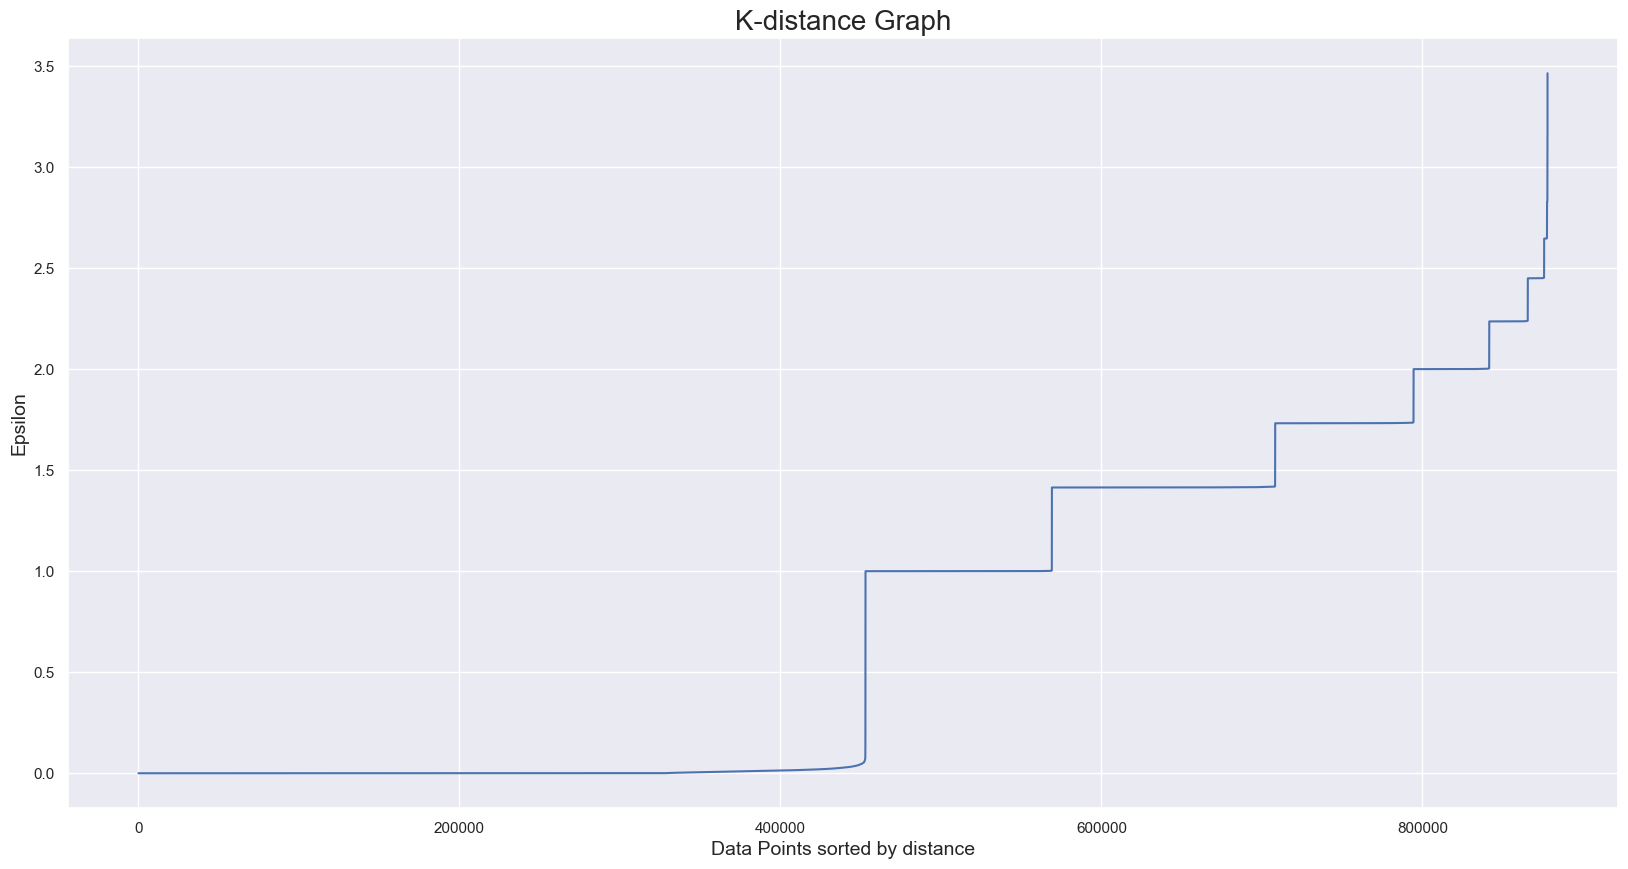

In [ ]:
neigh = NearestNeighbors(n_neighbors=24)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.figure(figsize=(20,10))
plt.plot(distances)
plt.title('K-distance Graph', fontsize=20)
plt.xlabel('Data Points sorted by distance', fontsize=14)
plt.ylabel('Epsilon', fontsize=14)
plt.show()

In [57]:
opt_eps_encontrado = 0.1

### 3.2.6 Aplicação do DBSCAN e sua respectiva visualização nas variáveis latitude e longitude)

In [58]:
dbscan = DBSCAN(eps=opt_eps_encontrado, min_samples=24).fit(X)

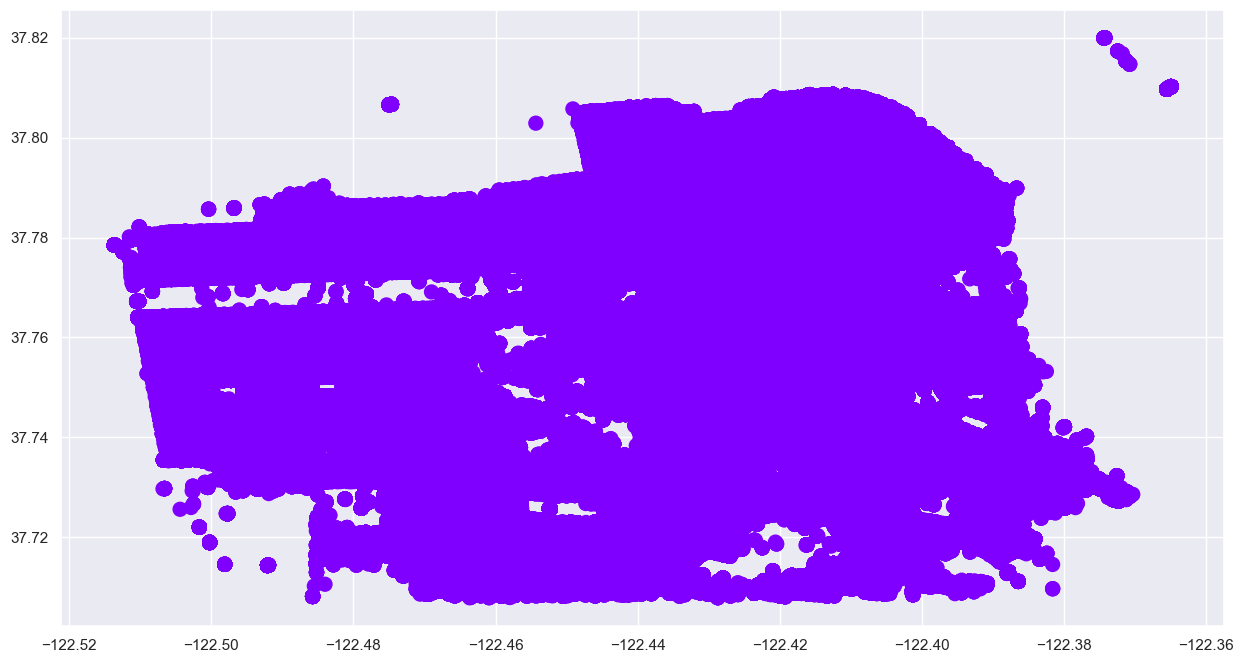

In [59]:
plt.figure(figsize=(15,8))
var1 = 0
var2 = 1
plt.scatter(X[:,var1], X[:,var2], s=100, c=dbscan.labels_, cmap='rainbow')

plt.show()